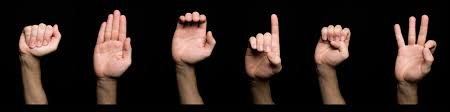



# **Yad-tech : Random Forest Model for Real time predication.**

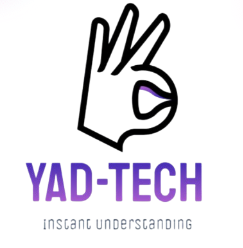

# **Introduction**
In this project, we aim to develop a sign language gesture recognition system using machine learning techniques, specifically a Random Forest model. The goal is to accurately classify various hand gestures representing letters, common phrases, and functional commands, like "delete" and "space." By leveraging Mediapipe's hand landmark detection, we transform each gesture into a structured set of features that the model can interpret. This project demonstrates the power of machine learning to facilitate communication for the deaf and hard-of-hearing community by providing a real-time solution for translating American Sign Language (ASL) gestures.

**The core objectives of this project are:**

1. Data Preparation: Extract hand landmarks from images using Mediapipe, and normalize these landmarks to ensure consistent inputs.

2. Model Training: Train a Random Forest classifier on the landmark data to recognize and classify ASL gestures accurately.

3. Evaluation: Assess the model's performance using accuracy, confusion matrix, and classification metrics to ensure reliable and robust gesture recognition.



This notebook outlines the steps taken to prepare data, build and evaluate the model, and discuss potential applications of the developed system in enhancing accessibility for non-verbal communication.

-----

# **1. Importing Libraries**

In [12]:
!pip install mediapipe
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import zipfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 24.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [2]:
 !unzip '/content/landmark_data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: landmark_data/U/101.jpg  
  inflating: landmark_data/U/102.jpg  
  inflating: landmark_data/U/103.jpg  
  inflating: landmark_data/U/104.jpg  
  inflating: landmark_data/U/105.jpg  
  inflating: landmark_data/U/106.jpg  
  inflating: landmark_data/U/107.jpg  
  inflating: landmark_data/U/108.jpg  
  inflating: landmark_data/U/109.jpg  
  inflating: landmark_data/U/11.jpg  
  inflating: landmark_data/U/110.jpg  
  inflating: landmark_data/U/111.jpg  
  inflating: landmark_data/U/112.jpg  
  inflating: landmark_data/U/113.jpg  
  inflating: landmark_data/U/114.jpg  
  inflating: landmark_data/U/115.jpg  
  inflating: landmark_data/U/116.jpg  
  inflating: landmark_data/U/117.jpg  
  inflating: landmark_data/U/118.jpg  
  inflating: landmark_data/U/119.jpg  
  inflating: landmark_data/U/12.jpg  
  inflating: landmark_data/U/120.jpg  
  inflating: landmark_data/U/121.jpg  
  inflating: landmark_data/U/122.jpg  
  inflating: la

# **2. Data Exploration (EDA)**

In [4]:
# Define paths for training and testing data
data_path = '/content/landmark_data'

# List the folders (each folder corresponds to a letter in the training set)
classes = os.listdir(data_path)

print(f"Training Classes: {classes}")
print(f"Total training classes: {len(classes)}")

Training Classes: ['Q', 'T', 'O', 'D', 'C', 'P', 'E', 'X', 'I', 'G', 'U', 'M', 'K', 'I Love You', 'S', 'W', 'DELETE', 'L', 'R', 'SPACE', 'Y', 'B', 'F', 'N', 'H', 'NOTHING', 'A', 'V', 'Hello']
Total training classes: 29


In [5]:
# Count the number of images in each class for training data
for class_name in classes:
    class_dir = os.path.join(data_path, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"Class {class_name} contains {num_images} training images")

Class Q contains 1000 training images
Class T contains 1000 training images
Class O contains 1000 training images
Class D contains 1000 training images
Class C contains 1000 training images
Class P contains 1000 training images
Class E contains 1000 training images
Class X contains 1000 training images
Class I contains 1000 training images
Class G contains 1000 training images
Class U contains 1000 training images
Class M contains 1000 training images
Class K contains 1000 training images
Class I Love You contains 1000 training images
Class S contains 1000 training images
Class W contains 1000 training images
Class DELETE contains 100 training images
Class L contains 1000 training images
Class R contains 1000 training images
Class SPACE contains 100 training images
Class Y contains 1000 training images
Class B contains 1000 training images
Class F contains 1000 training images
Class N contains 1000 training images
Class H contains 1000 training images
Class NOTHING contains 0 training 

In [ ]:
# Display a sample image from each class in the training set
for class_name in classes[:28]:  # Display samples for 5 classes
    class_dir = os.path.join(data_path, class_name)
    sample_image_path = os.path.join(class_dir, os.listdir(class_dir)[0])

    img = Image.open(sample_image_path)
    plt.imshow(img)
    plt.title(f"Class: {class_name}")
    plt.show()

# Check test images (from the test folder)
test_images = os.listdir(data_path)
print(f"Test Images: {test_images}")

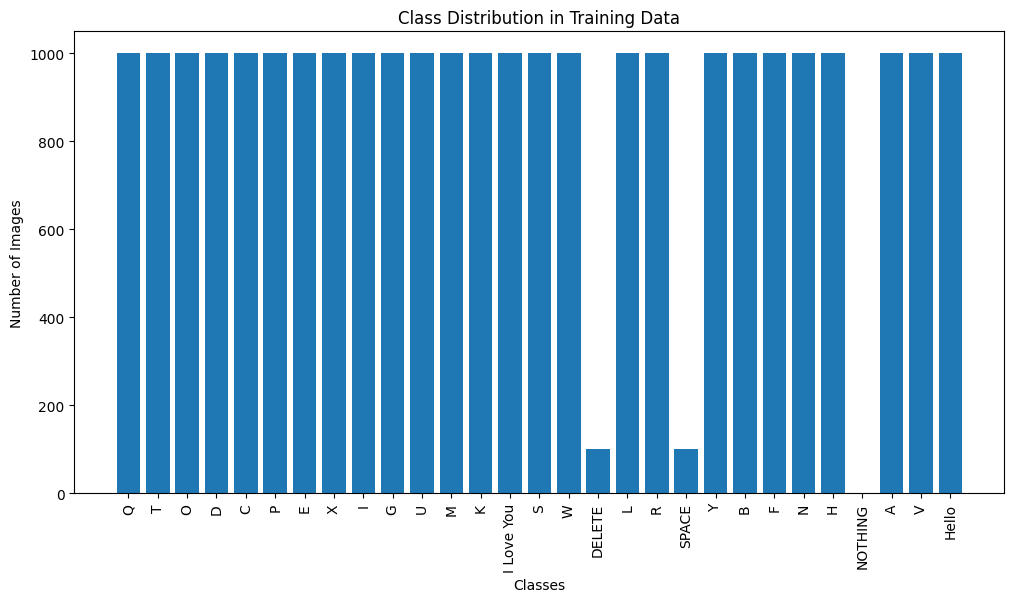

In [7]:
# Count the number of images per class in the training set
class_counts = {}

for class_name in classes:
    class_dir = os.path.join(data_path, class_name)
    num_images = len(os.listdir(class_dir))
    class_counts[class_name] = num_images

# Plot the class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title('Class Distribution in Training Data')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

View a Few Samples Per Class

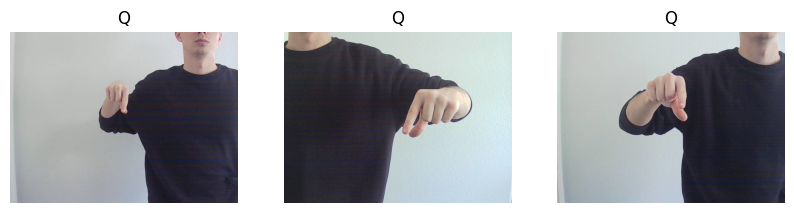

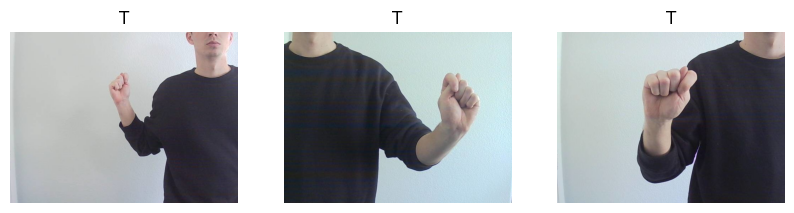

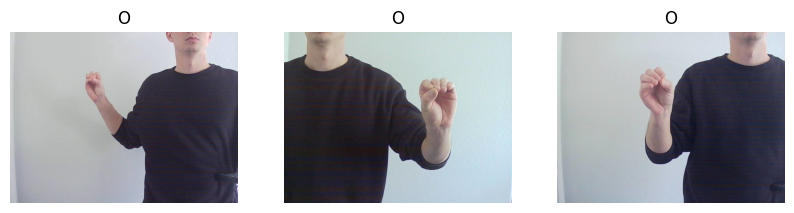

In [8]:
# Display multiple images per class
def display_images_per_class(class_name, num_images=3):
    class_dir = os.path.join(data_path, class_name)
    sample_images = os.listdir(class_dir)[:num_images]

    plt.figure(figsize=(10, 5))
    for i, image_file in enumerate(sample_images):
        img = Image.open(os.path.join(class_dir, image_file))
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Display for a few selected classes
for class_name in classes[:3]:  # Display for the first 3 classes
    display_images_per_class(class_name)

In [9]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

# Define paths
base_path = '/content/landmark_data'
delete_class_path = os.path.join(base_path, 'DELETE')
space_class_path = os.path.join(base_path, 'SPACE')
nothing_class_path = os.path.join(base_path, 'NOTHING')

# 1. Remove the "NOTHING" class folder if it exists
if os.path.exists(nothing_class_path):
    shutil.rmtree(nothing_class_path)
    print("Removed 'NOTHING' class folder.")

# 2. Data Augmentation for "DELETE" and "SPACE" Classes
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define function for augmentation
def augment_class_images(class_path, target_count=1000):
    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith('.jpg')]
    num_images = len(images)
    if num_images >= target_count:
        print(f"'{class_path}' already has sufficient images.")
        return

    # Load images and perform augmentation
    for i in range(target_count - num_images):
        img_path = np.random.choice(images)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.expand_dims(img, 0)  # Expand dims for datagen

        # Generate augmented image
        aug_iter = datagen.flow(img, batch_size=1)
        aug_img = next(aug_iter)[0].astype(np.uint8)

        # Save augmented image
        aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(class_path, f"aug_{i}.jpg"), aug_img_bgr)

    print(f"Augmented '{class_path}' to reach {target_count} images.")

# Augment images in "DELETE" and "SPACE" classes
augment_class_images(delete_class_path, target_count=1000)
augment_class_images(space_class_path, target_count=1000)


Removed 'NOTHING' class folder.
Augmented '/content/landmark_data/DELETE' to reach 1000 images.
Augmented '/content/landmark_data/SPACE' to reach 1000 images.


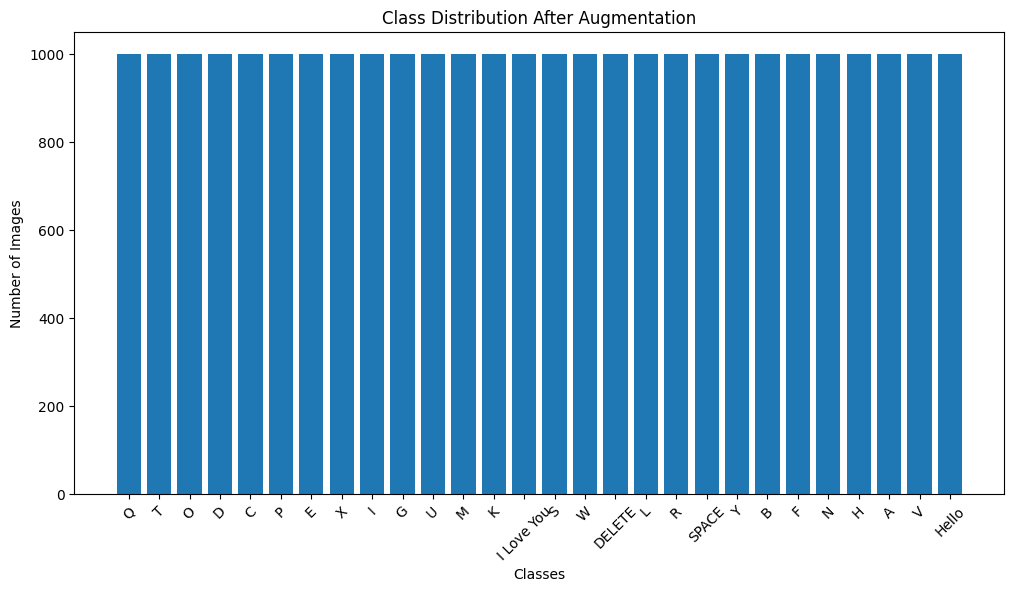

In [10]:
import os
import matplotlib.pyplot as plt

base_path = '/content/landmark_data'

# Count the number of images in each class
class_counts = {}
for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len([img for img in os.listdir(class_path) if img.endswith('.jpg')])

# Plotting the class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution After Augmentation")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


# **3: Extract Hand Landmarks Using Mediapipe**

Landmarks represent the positions of specific key points (fingers, palm base, etc.) of the hand in each image.
Normalization of landmarks relative to the minimum x and y values ensures that landmark positions are consistent regardless of where the hand appears in the image. This improves model robustness by reducing dependency on the hand’s absolute position in the frame ( since we are using a combination of our own data and public data)

In a nutshell, landmark extraction with Mediapipe works like this:

Hand Detection: Mediapipe processes each image to detect a hand and identify key points (landmarks) on it, such as fingertips and joints.

Coordinate Extraction: Each detected landmark's position is extracted as x and y coordinates, normalized to fall between 0 and 1 based on the image dimensions.

Normalization and Anchoring: The coordinates are shifted so that the hand’s position in the frame doesn’t affect recognition. This "anchors" the landmarks, making the model more robust to hand positioning.

Data Collection: These adjusted coordinates for each image are saved as inputs for training the model, representing each sign’s unique hand shape and orientation.

In [13]:
import mediapipe as mp

# Initialize Mediapipe for hand detection
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3, max_num_hands=1)

# Paths
directory = '/content/landmark_data'
# Landmark Extraction Loop
data, labels = [], []

# Loop through each folder and image
for dir_ in os.listdir(directory):
    for img_path in os.listdir(os.path.join(directory, dir_)):
        data_aux, x_, y_ = [], [], []
        img = cv2.imread(os.path.join(directory, dir_, img_path))

        if img is None:
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(img_rgb)
        hand_landmarks = results.multi_hand_landmarks[0] if results.multi_hand_landmarks else None

# Normalizing and Padding Landmarks
        if hand_landmarks:
            for i in range(len(hand_landmarks.landmark)):
                x, y = hand_landmarks.landmark[i].x, hand_landmarks.landmark[i].y
                x_.append(x)
                y_.append(y)
            for i in range(len(hand_landmarks.landmark)):
                x, y = hand_landmarks.landmark[i].x, hand_landmarks.landmark[i].y
                data_aux.extend([x - min(x_), y - min(y_)])

            data.append(data_aux)
            labels.append(dir_)

# Padding data to ensure equal length for all samples
max_length = max(map(len, data))
data_padded = [sublist + [0] * (max_length - len(sublist)) for sublist in data]



NameError: name 'pickle' is not defined

note: ignore the error , we solved it in the next block but didnt want to re-run the cell because its not needed

In [15]:
import pickle

# Save the processed data for later use
with open('/content/landmark_data.pkl', 'wb') as file:
    pickle.dump({'data': data_padded, 'labels': labels}, file)

# **5: Train the Random Forest Model**

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

# Load processed data
data_dict = pickle.load(open('/content/landmark_data.pkl', 'rb'))
data = np.asarray(data_dict['data'])
labels = np.asarray(data_dict['labels'])

# Split data
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels) #training :80%, test 20%

# Train Random Forest Classifier
model = RandomForestClassifier()
model.fit(x_train, y_train)

# Evaluate model
y_pred = model.predict(x_test)
score = accuracy_score(y_pred, y_test)
print(f'Accuracy: {score * 100:.2f}%')

# Save the trained model
with open('/content/landmark_model.pkl', 'wb') as file:
    pickle.dump({'model': model}, file)
    #note: prevents the need to reprocess all images for landmarks each time you run the code, saving time and computational resources. When you want to use this data, you can simply load it from this file instead of re-running the entire processing step.


Accuracy: 99.80%


# **6: Results Visualization and Evaluation**


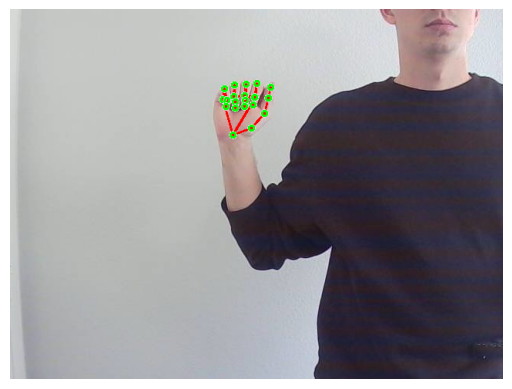

In [20]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import os

# Initialize Mediapipe and set up paths
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
dataset_path = '/content/landmark_data'  # Path to your dataset

# Load a sample image
sample_folder = 'A'  # Replace with any class folder you want to visualize
sample_image_path = os.path.join(dataset_path, sample_folder, '0.jpg')  # Replace '0.jpg' with an image from that folder
img = cv2.imread(sample_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Mediapipe

# Process the image to detect hand landmarks
with mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3) as hands:
    results = hands.process(img_rgb)

    # Check if landmarks were detected
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw landmarks on the image
            mp_drawing.draw_landmarks(
                img_rgb,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=3),
                mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
            )
    else:
        print("No hand landmarks detected in the sample image.")

# Plot the image with landmarks
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


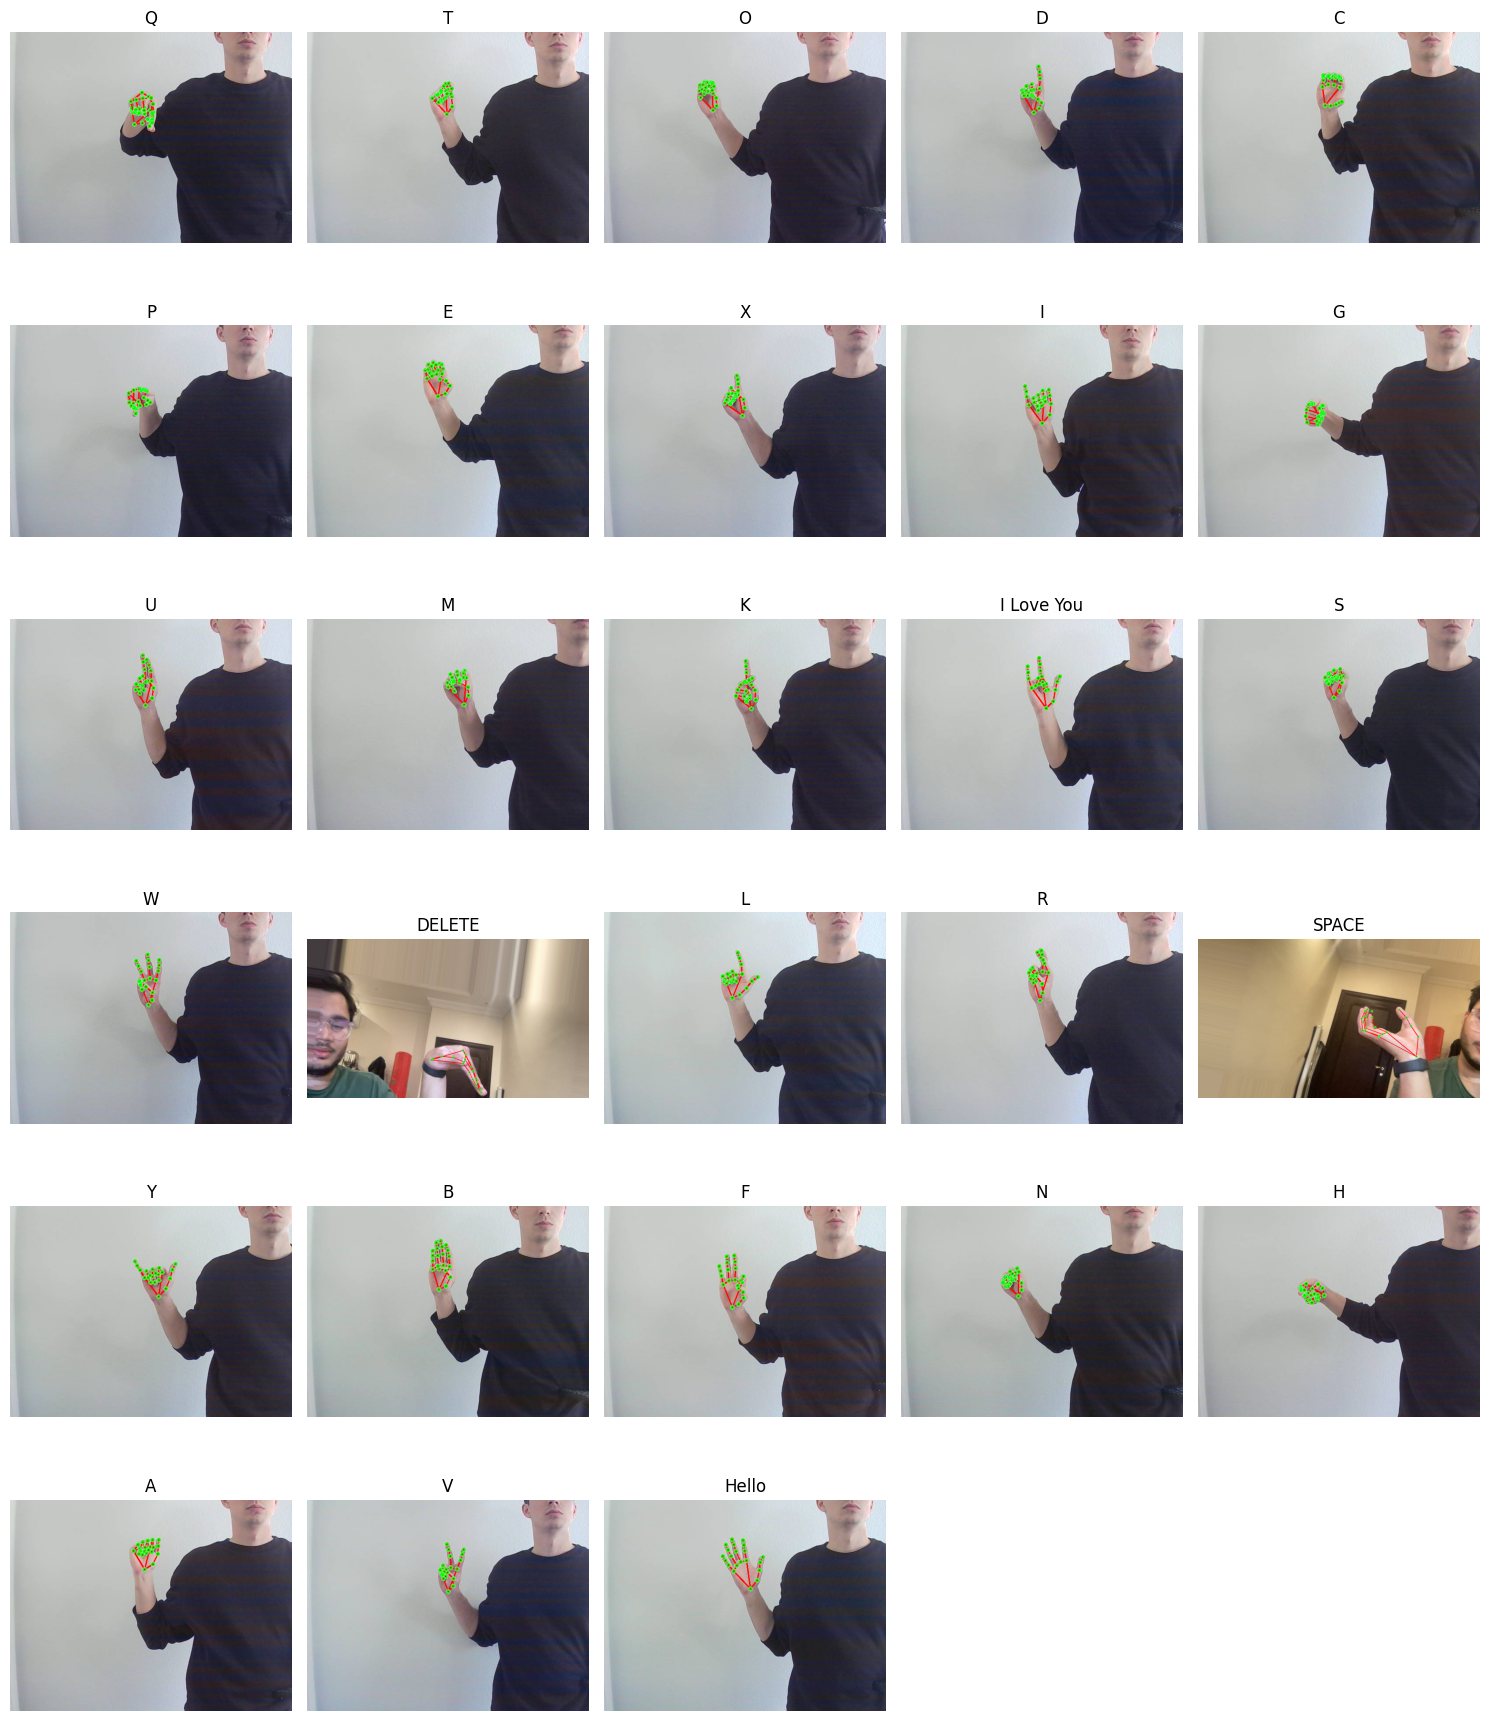

In [21]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import os

# Initialize Mediapipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Path to the dataset
dataset_path = '/content/landmark_data/'
class_folders = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Set up the grid for visualization
num_classes = len(class_folders)
cols = 5
rows = (num_classes // cols) + (num_classes % cols > 0)
fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 3))

# Loop through each class folder
for idx, folder in enumerate(class_folders):
    folder_path = os.path.join(dataset_path, folder)
    img_files = [img_file for img_file in os.listdir(folder_path) if img_file.endswith('.jpg')]

    # Load a sample image from the folder
    if img_files:
        img_path = os.path.join(folder_path, img_files[0])  # Take the first image in the folder
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Process the image to detect hand landmarks
        with mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3) as hands:
            results = hands.process(img_rgb)

            # Draw landmarks if detected
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(
                        img_rgb,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=3),
                        mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
                    )

        # Display the image in the grid
        ax = axs[idx // cols, idx % cols]
        ax.imshow(img_rgb)
        ax.set_title(folder)
        ax.axis('off')
    else:
        print(f"No images found in folder {folder}")

# Hide any unused subplots if the grid is larger than the number of classes
for j in range(idx + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

fig.tight_layout()
plt.show()


**Handling the "Nothing" Class**

In this project, we encountered a limitation with Mediapipe's hand detection when processing images for the "nothing" class. Mediapipe’s hand landmark detection relies on visible hand patterns within an image to identify and extract landmarks. Consequently, it cannot detect or process images where no hand is present, meaning we are unable to generate feature data for the "nothing" class.

Given this limitation, we have chosen to simply ignore the "nothing" class in our model. This decision allows us to proceed with classifying gestures without introducing additional complexity to handle images with no detectable hand features.

In [22]:
# Save the RandomForest model
with open("sign_language_model.pkl", "wb") as file:
    pickle.dump(model, file)

# **7: Evaluate Model with Confusion Matrix and Classification Report**

**The high accuracy achieved by our Random Forest model is likely due to the following factors:**

Distinctive Landmark Patterns in Sign Language Gestures:

Each sign language gesture has unique hand shapes, orientations, and finger positions. Mediapipe landmarks capture these patterns precisely, allowing the model to differentiate between signs effectively.
Since each class (sign) has a distinct hand structure, the model can learn and separate classes based on these clear differences.
Normalization of Landmarks:

By normalizing the coordinates of each landmark relative to the minimum x and y values in each image, we ensure that each sign’s hand position is consistent regardless of its position in the frame. This allows the model to focus on the shape of the hand rather than its location in the image, which reduces noise and improves generalization.
High-Quality, Well-Organized Dataset:

If the dataset is balanced across classes and free from noise (clear, well-lit images), it helps the model learn each class with minimal bias. This results in more accurate recognition across different sign classes.
Strength of Random Forest with Structured Data:

Random Forest models work well with structured data, such as hand landmarks, because each landmark’s position provides consistent features. With decision trees as its foundation, Random Forest can effectively capture complex, non-linear relationships in the data, making it ideal for sign language gesture recognition.

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

Accuracy: 99.80%
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       200
           B       1.00      1.00      1.00       200
           C       1.00      1.00      1.00       196
           D       1.00      1.00      1.00       200
      DELETE       1.00      0.98      0.99       148
           E       1.00      1.00      1.00       198
           F       1.00      1.00      1.00       200
           G       0.99      0.98      0.99       200
           H       0.98      0.99      0.98       195
       Hello       1.00      1.00      1.00       200
           I       1.00      0.99      1.00       200
  I Love You       1.00      1.00      1.00       200
           K       1.00      1.00      1.00       200
           L       1.00      1.00      1.00       200
           M       1.00      0.99      1.00       200
           N       0.98      1.00      0.99       200
           O       1.00      1.00      1.

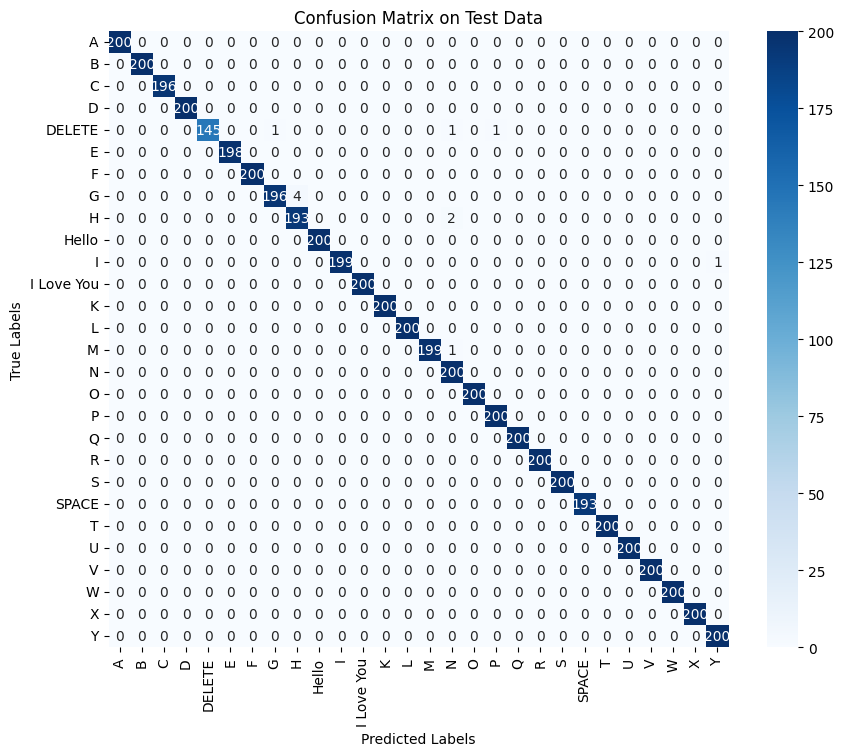

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Confusion Matrix and Classification Report
def evaluate_model_on_test_data(model, x_test, y_test):
    # Predict the labels for the test data
    y_pred = model.predict(x_test)

    # Print accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix on Test Data")
    plt.show()

evaluate_model_on_test_data(model, x_test, y_test)


**Model Evaluation Analysis:**


The confusion matrix shows that the model performs exceptionally well across all classes, with almost perfect classification for each sign.
The model misclassifies very few instances, as shown by the small number of off-diagonal values, suggesting minimal errors.
Accuracy and Classification Report:

Accuracy: The model achieved an accuracy of 99.8%, which indicates it’s highly effective at recognizing and classifying signs.


Precision, Recall, and F1-Score: Each class shows nearly perfect scores (close to 1.00) in precision, recall, and F1-score, confirming consistent performance across all gestures. This balanced performance is crucial for real-time applications to avoid biases toward any specific gesture.




# **Closing**

In summary, this project successfully demonstrates a machine learning approach to ASL gesture recognition using a Random Forest model trained on hand landmark data. The high accuracy achieved, as shown by the confusion matrix and classification report, reflects the model’s effectiveness in classifying a wide range of gestures with minimal misclassification. The preprocessing techniques, such as landmark extraction and normalization, played a crucial role in preparing the data for reliable model performance

This project lays the groundwork for further development in real-time sign language recognition, providing a foundation for accessible communication technologies that bridge the gap for the deaf and hard-of-hearing community.

Work done by the **Yad-Tech team**